# RCE CAPE exploration

### Importing libraries and setting plotting parameters

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statistics as stat
import random

plt.rcParams.update({'font.size': 14})

### Data extraction

In [2]:
def file_concatenator(numerical_list):
    
    #creates a series of file names in netcdf format using a numerical list
    
    file_names = []
    
    for value in numerical_list:
        
        basedir = '/work/bb1018/b380873/MCS_clim/ausgabe/meteo_clim/nc/ERAI/'
        
        file_names = np.append(file_names,(basedir + 'colloc_'+str(value)+'_NZ.nc'))
        
    return file_names

def nc_open_compile(files,variable_name,compile_type='append',indices=slice(0,None)):
    
    #opens netcdf files, in a list, and either stacks or appends the data
    
    #files = list containing file names
    #variable_name is a string of the desired variable
    #compile_type allows you to stack or append data from each file
    #indices requires slice input, allows specific rows to be taken from each file
    #~~~~ hope to improve function with isel xarray method to select certain columns,rows
    #~~~~ based on dictionary labels, i.e. taking altitude 15 with .isel(altitude = slice(14,15))..!
    
    #opens a file in 'files' and extracts data for a given variable
    
    for i,file in enumerate(files):
        
        if i == 0:
            
            variable = (xr.open_dataset(file))[variable_name][indices]
        
        else:
            
            #kwarg assumes append, but vstack can also be used
            if compile_type == 'stack':
            
                variable = np.vstack((variable,(xr.open_dataset(file))[variable_name][indices]))
            
            else:
                
                variable = np.append(variable,(xr.open_dataset(file))[variable_name][indices])
                   
    return variable

def negative_to_nan(array):
    #simply converts negatives to NaNs
    
    array = np.where(array<0, np.NaN, array)
    
    return array

#array of years
years = np.arange(1983,2008)

#create list of file names
file_years = file_concatenator(years)

#using nc_open_compile to open data for cape,pmax and w
cape_array = nc_open_compile(file_years,'cape')

pmax_array = nc_open_compile(file_years,'pmax')

#w is data is stacked and then the 15th altitude column is taken
w_array = nc_open_compile(file_years,'w','stack')

w_array_mid = w_array[:,14]

Below we plot a general scatter graph of the pressure velocity vs the CAPE. This is to give a general indication of the distributions of pressure velocities.

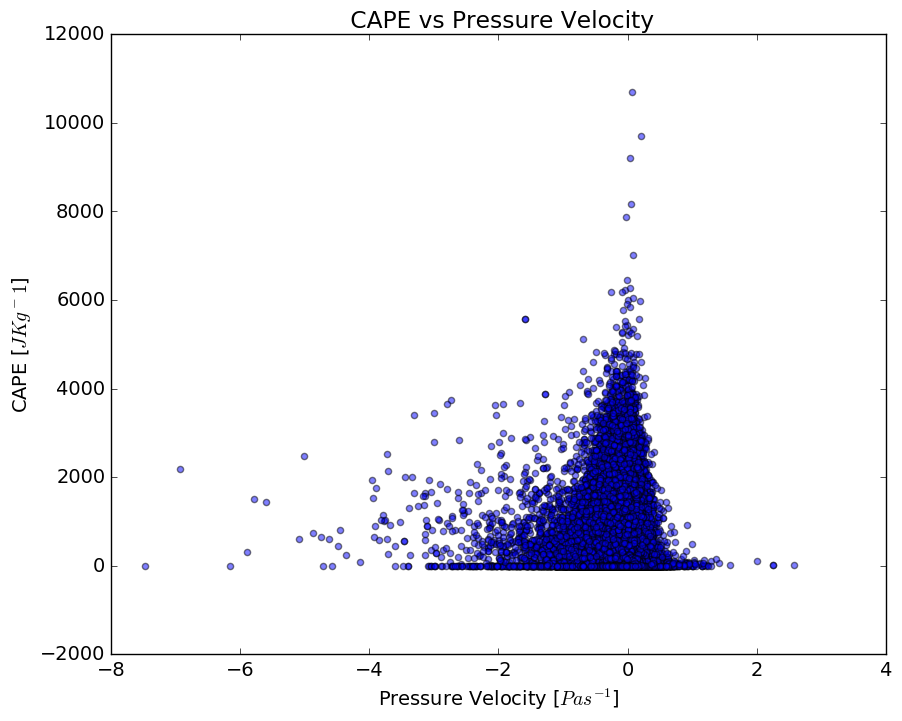

In [3]:
#figure created
fig,ax = plt.subplots(figsize = (10,8))

#values scattered with transparency half
ax.scatter(w_array_mid,cape_array,alpha=0.5)

#labels and title made
ax.set(xlabel = "Pressure Velocity [$Pa s^{-1}$]" )

ax.set(ylabel = "CAPE [$J Kg^-1$]")

ax.set_title(' CAPE vs Pressure Velocity')

plt.show()


We observe that the underside of the distribution is much more chaotic and extensive, suggesting greater maximum negative pressure velocities than positive values. It also suggests a greater abundance of negative pressure velocities in general.

Below we separate the negative values and apply the modulus to them so that they can be used with a logarithm later on.

In [4]:
def negative_vals(y,x):
    #function to take negative values in some array y and couple with corresponding x values
    
    #taking array values less than 0, negative values
    indices = np.where(y<0)

    #creating a new array of just negative values from w
    y_n = y[indices]

    #taking cape values corresponding to negative w
    x_n = x[indices]

    #making the values positive for logarithms
    y_n = abs(y_n)
    
    return y_n,x_n

w_array_n,cape_array_n = negative_vals(w_array_mid,cape_array)


Below, functions are created to find the maximum values of arrays and these are applied to find the greatest precipitation or pressure velocity values in each CAPE bin.

In [5]:
def nan_array(shape):
    
    an_array = np.empty(shape)

    an_array[:] = np.NaN
    
    return an_array

def maxk(matrix,k):
    #returns values of max k elements of a matrix
    
    matrix_new = matrix.flatten()
    
    matrix_new = np.sort(matrix_new)
    
    return matrix_new[-k:]

def maxk_arg(matrix,k):
    #returns indices of max k elements in a matrix
    
    matrix_new = matrix.flatten()
    
    matrix_arg = np.argsort(matrix_new)
    
    return matrix_arg[-k:]

def bin_max_function(n_bins,lower,upper,x_variable,variable_1,n_max=5):
    #Creates a range of bin values within which the data should lie, collects indices of x-variables
    #which fall in those bins and finds corresponding values associated with two other variables.
    #A number of max values of the main variable of interest, variable 1, are collected and then the associated
    #indices of the other variables too.
    
    #n_bins = number of bins, lower and upper = bounds of bins, variable 1 is the y variable,
    
    #n_max is the number of large
    
    values = np.linspace(lower,upper,n_bins)
    
    x_vals = nan_array((n_bins,1)) 
    var1_vals = nan_array((n_bins,1))

    values_red = values[:-1]
    
    for i,value in enumerate(values_red):
        
        j = np.where((x_variable >= value) & (x_variable < values[i+1]))

        x = x_variable[j]
        
        var1 = variable_1[j]
        
        if len(j[0]) >= n_max:
        
            j = maxk_arg(var1,n_max)
        
        
            if i == 0:
            
                x_vals = x[j]
            
                var1_vals = var1[j]
            
            else:
            
                #print(np.shape(x_vals),np.shape(x[j]))
                x_vals = np.vstack((x_vals,x[j]))
            
                var1_vals = np.vstack((var1_vals,var1[j]))
        
    return x_vals, var1_vals

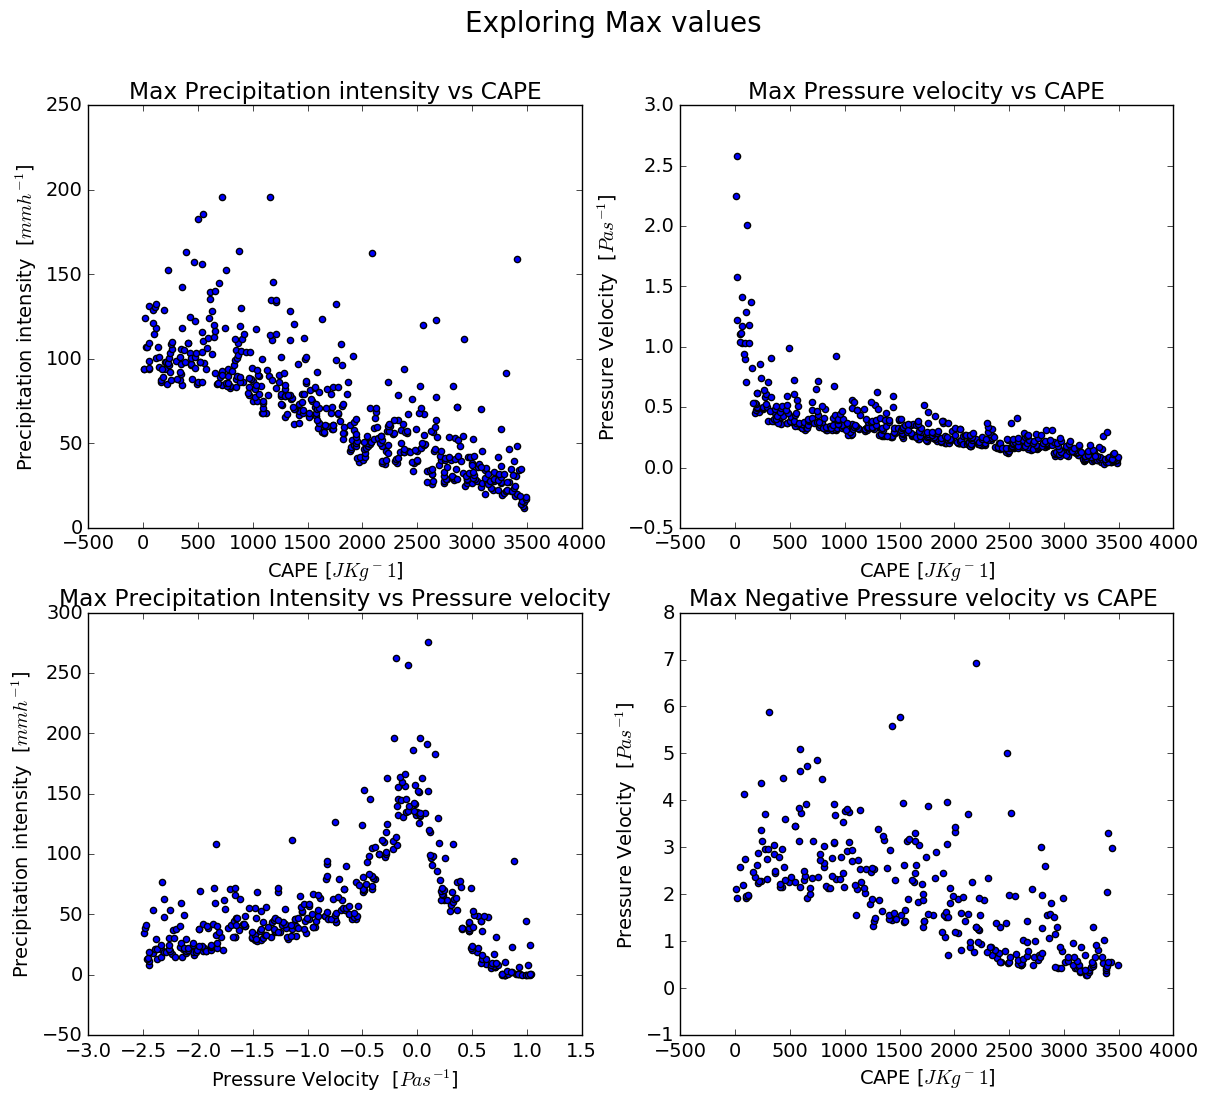

In [6]:
#cape and pmax values associated with max precipitation are extracted
cape_values_p,pmax_values = bin_max_function(50,10,3500,cape_array,pmax_array,n_max =10)

##cape and pressure velocity (w) values associated with max pressure velocity are extracted
cape_values_w,w_values = bin_max_function(50,10,3500,cape_array,w_array_mid,n_max =10)


#Extracting values corresponding to negative pressure velocites
cape_values_n,w_values_n = bin_max_function(30,10,3500,cape_array_n,w_array_n,n_max =10)

#Binning precipitation by Pressure velocity
w_values_p,pmax_values_w = bin_max_function(60,-2.5,3,w_array_mid,pmax_array,n_max =10)

x_values = [cape_values_p,cape_values_w,w_values_p,cape_values_n]
x_labels = ['CAPE [$J Kg^-1$]','CAPE [$J Kg^-1$]',
            'Pressure Velocity  [$Pa s^{-1}$]','CAPE [$J Kg^-1$]']

y_values = [pmax_values,w_values,pmax_values_w,w_values_n]
y_labels = ["Precipitation intensity  [$mm h^{-1}$]",
            "Pressure Velocity  [$Pa s^{-1}$]","Precipitation intensity  [$mm h^{-1}$]",
           "Pressure Velocity  [$Pa s^{-1}$]"]

titles = ['Max Precipitation intensity vs CAPE','Max Pressure velocity vs CAPE',
          'Max Precipitation Intensity vs Pressure velocity','Max Negative Pressure velocity vs CAPE ']
       
    
fig, axes = plt.subplots(2,2,figsize=(14,12))

fig.suptitle('Exploring Max values',size=20)

for i,axis in enumerate(axes.flat):
    
    axis.scatter(x_values[i],y_values[i])
    #ax.scatter(np.log(x_values[i]),np.log(y_values[i]))

    axis.set(xlabel = x_labels[i])
    axis.set(ylabel = y_labels[i])
    axis.set_title(titles[i])
    
plt.show()

The above image shows the max precipitation vs CAPE, the max positive pressure velocity vs CAPE, the max precipitation vs pressure velocity and then the maximum negative pressure velocity vs CAPE. All three plots concerning CAPE directly indicate clear negative trends in extreme behaviour with increasing cape. However, the profiles of the two plots concerning pressure velocity and CAPE are very different for positive and negative values. The positive pressure velocities seem to produce a far better defined trend, with a less great gradient and reaching lower magnitudes than the negative pressure velocities. The third plot clearly indicates non-linear interaction between precipitation and Pressure velocity. The precipitation intensity increases in a steady near linear manner from great negative values, but then peaking and assuming a more Gaussian form tending to 0 precipitation intensity for positive pressure velocities.

Below, I have attempted to fit an amplitude resonance curve to the data, with little success.

### Precipitation vs Pressure Velocity:  Fitting

[  14.62311149   15.07825335   15.80070447   16.11151611   16.79162151
   17.9409852    18.91883206   19.66567022   21.25652624   22.45912003
   24.0139304    24.74897548   25.95045194   28.82866856   31.72565088
   33.33679272   34.91606345   39.2239174    45.61713545   47.19814151
   54.0698723    69.08440088   72.2386966    93.71051491  121.82431475
  140.64724065  154.64214121  144.54968076  117.28537223  113.75676471
   84.9587507    76.35213649   64.38389125   56.35829561   50.62888256
   41.88607187   40.12875821   33.66464337]


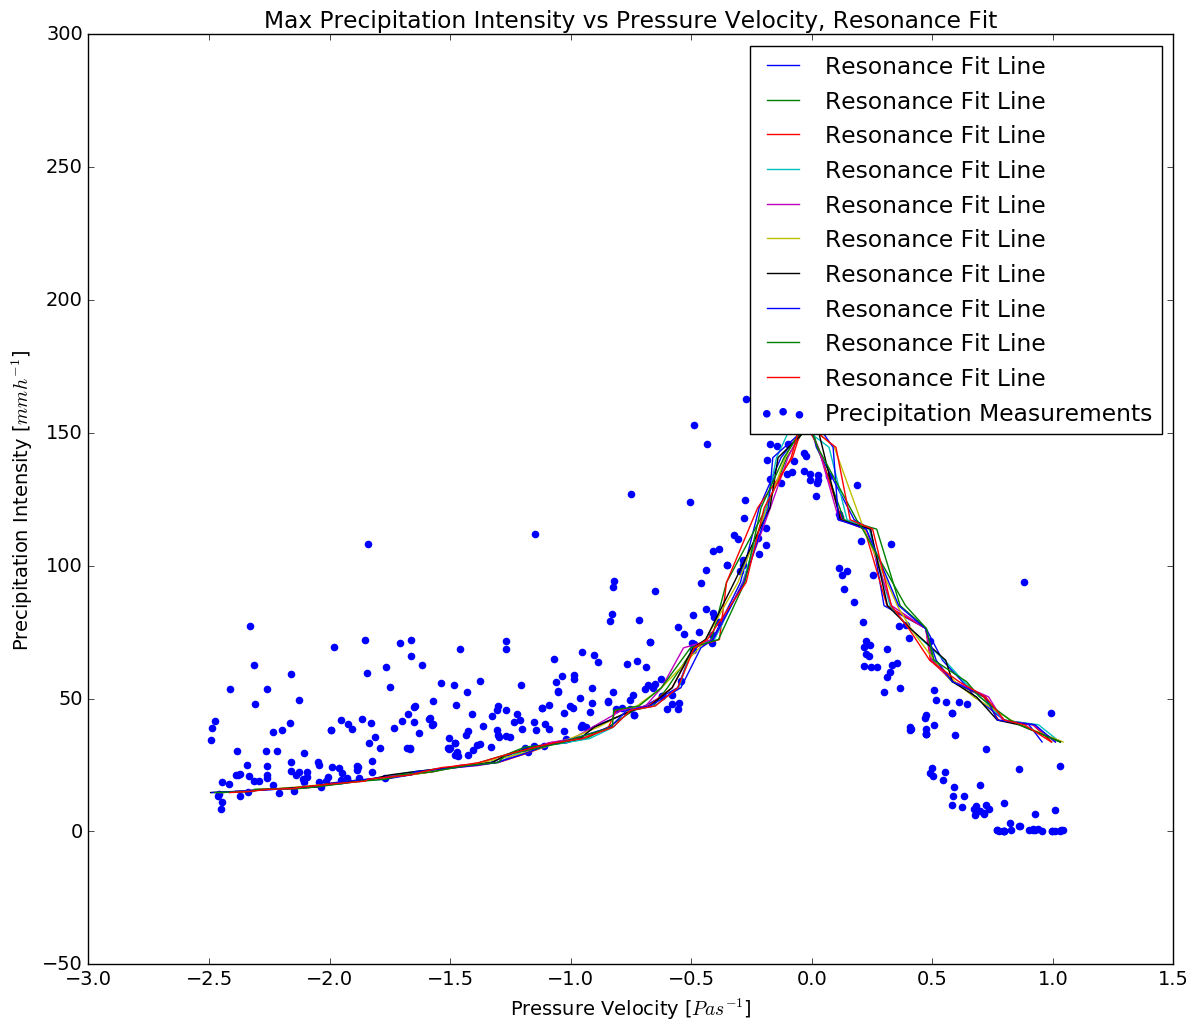

In [7]:
def resonance_function(x_data,a,b,c,d):
    #simple resonance amplitude function
    
    amplitude = a/(np.sqrt((b*(x_data)**2 -c)**2 + (d*x_data)**2))
    
    return amplitude

#extracting fit parameters and covariance values using resonance fit
ppar_r,pcov_r = curve_fit(resonance_function,(w_values_p[~np.isnan(w_values_p)]).flatten(),
                          (pmax_values_w[~np.isnan(pmax_values_w)]).flatten())


#values for fit line produced using fit parameters
resonance_values = resonance_function(w_values_p,ppar_r[0],
                                      ppar_r[1],ppar_r[2],ppar_r[3])

resonance_values = resonance_values[:,5]

print(resonance_values )

#creating a figure object
fig,ax = plt.subplots(figsize=(14,12))

#setting labels and title
ax.set_title('Max Precipitation Intensity vs Pressure Velocity, Resonance Fit')
ax.set(xlabel='Pressure Velocity [$Pa s^{-1}$]',ylabel='Precipitation Intensity [$mm h^{-1}$] ')

#scattering values
ax.scatter(w_values_p,pmax_values_w,color='blue',label='Precipitation Measurements')

#creating fit line
ax.plot(w_values_p,resonance_values,label='Resonance Fit Line')

plt.legend()

plt.show()


### Exploring Max Pressure Velocity vs Cape Over Different Pressure Levels

We now look to explore whether the trend of decreasing pressure velocity vs CAPE holds for different pressure levels. First we look at simply scattering for negative and positive pressure velocity, but now for pressure levels at the top,middle and bottom of the cloud system.

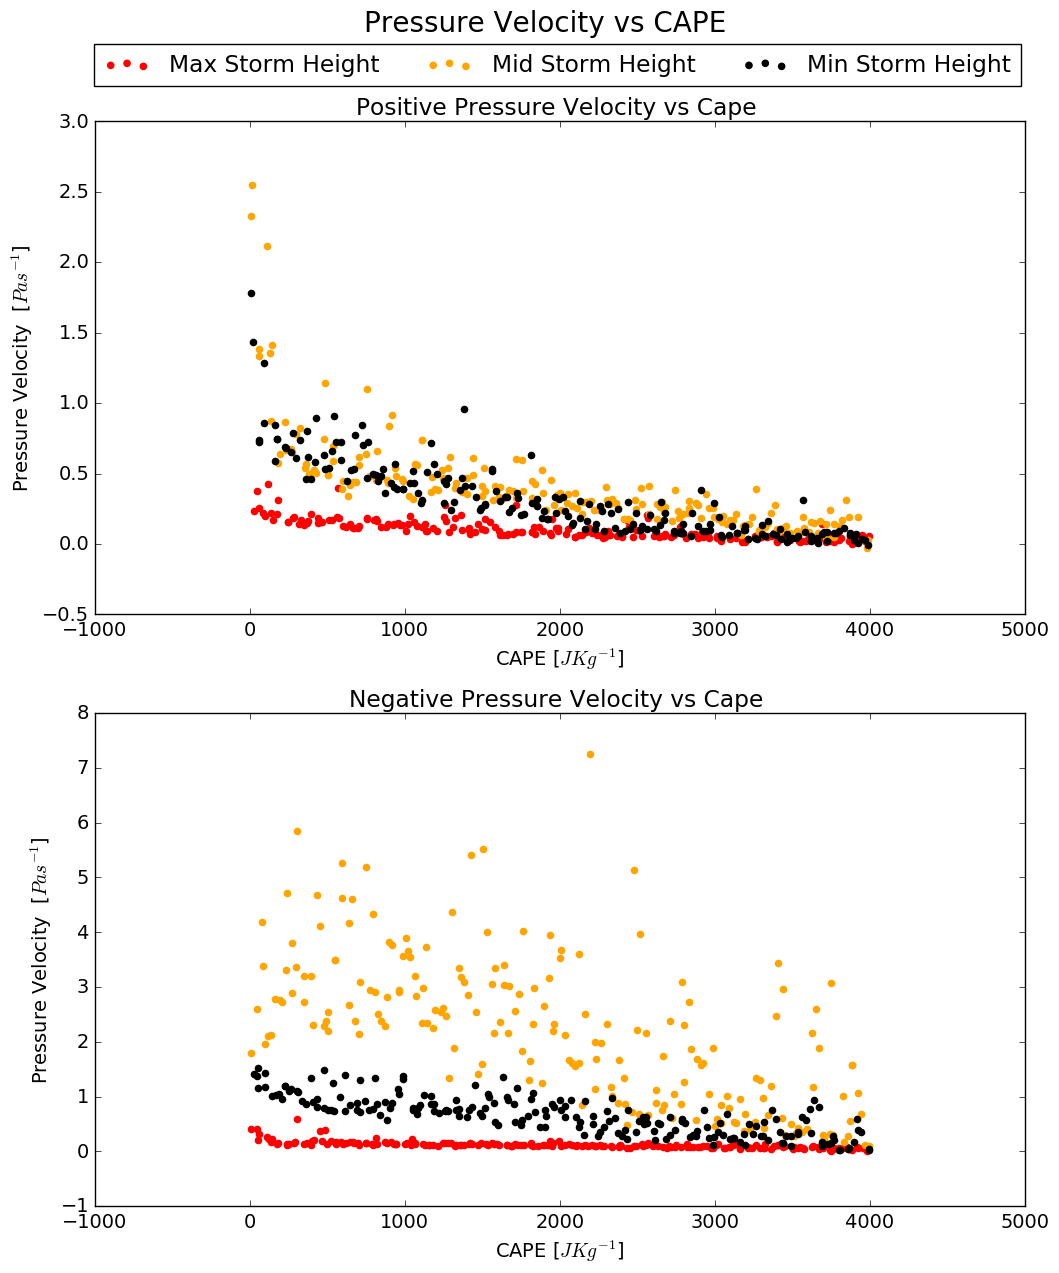

In [11]:
#pressure levels are opened
plev = np.double((xr.open_dataset(file_years[0])).pressure.data)

#w is data is stacked and then the top,middle and bottom altitude columns are taken
w_array = nc_open_compile(file_years,'w','stack')

w_0 = w_array[:,0]

w_15 = w_array[:,15]

w_31 = w_array[:,31]

def negative_vals(y,x):
    #taking array values less than 0, negative values
    indices = np.where(y<0)

    #creating a new array of just negative values from w
    y_n = y[indices]

    #taking cape values corresponding to negative w
    x_n = x[indices]

    #making the values positive for logarithms
    y_n = abs(y_n)
    
    return y_n,x_n

#w arrays joined
w_arrays = [w_0,w_15,w_31]

#labels collected
labels = ['Max Storm Height','Mid Storm Height','Min Storm Height']

#colours collected
colors = ['red','orange','black']

#figure created
fig,(ax1,ax2) = plt.subplots(2,1,figsize = (12,14))

#suptitle made
fig.suptitle('Pressure Velocity vs CAPE',size=20)

#titles and labels set
ax1.set_title('Positive Pressure Velocity vs Cape ')
ax1.set(xlabel='CAPE [$J Kg^{-1}$]')
ax1.set(ylabel= "Pressure Velocity  [$Pa s^{-1}$]")

ax2.set_title('Negative Pressure Velocity vs Cape ')
ax2.set(xlabel='CAPE [$J Kg^{-1}$]')
ax2.set(ylabel= "Pressure Velocity  [$Pa s^{-1}$]")

for i,w in enumerate(w_arrays):
    
    w_n,cape_n = negative_vals(w,cape_array)
    
    cape_bins,w_vals = bin_max_function(100,10,4000,cape_array,w,n_max =2)
    
    ax1.scatter(cape_bins,w_vals,color=colors[i],label=labels[i])
    
    cape_bins_n,w_vals_n = bin_max_function(100,10,4000,cape_n,w_n,n_max =2)
    
    ax2.scatter(cape_bins_n,w_vals_n,color=colors[i],label=labels[i])
    
plt.legend(ncol=3,bbox_to_anchor=(1.008,2.38))
    
plt.show()


In the above plots we can make 3 main observations. Firstly, the negative trend is maintained for max pressure velocity values vs cape, although it is very weak for the max pressure level. The extension of this negative trend over the 3 broad sections of the cloud strongly supports previous conclusions about these two measurements, making it more general and rigorous. Secondly, We again observe that negative pressure velocities widely have much greater absolute values. As before, the negative pressure velocity values also appear generally more scattered, particularly in the middle cloud case. Lastly, both plots show that the mid cloud pressure level produces the steapest line,followed by the bottom of the cloud and then the top.

In the next cell we seek to extend these conclusions by iterating over all pressure levels, hoping to find some functional behaviour of the pressure velocity against pressure level, negative and positive.

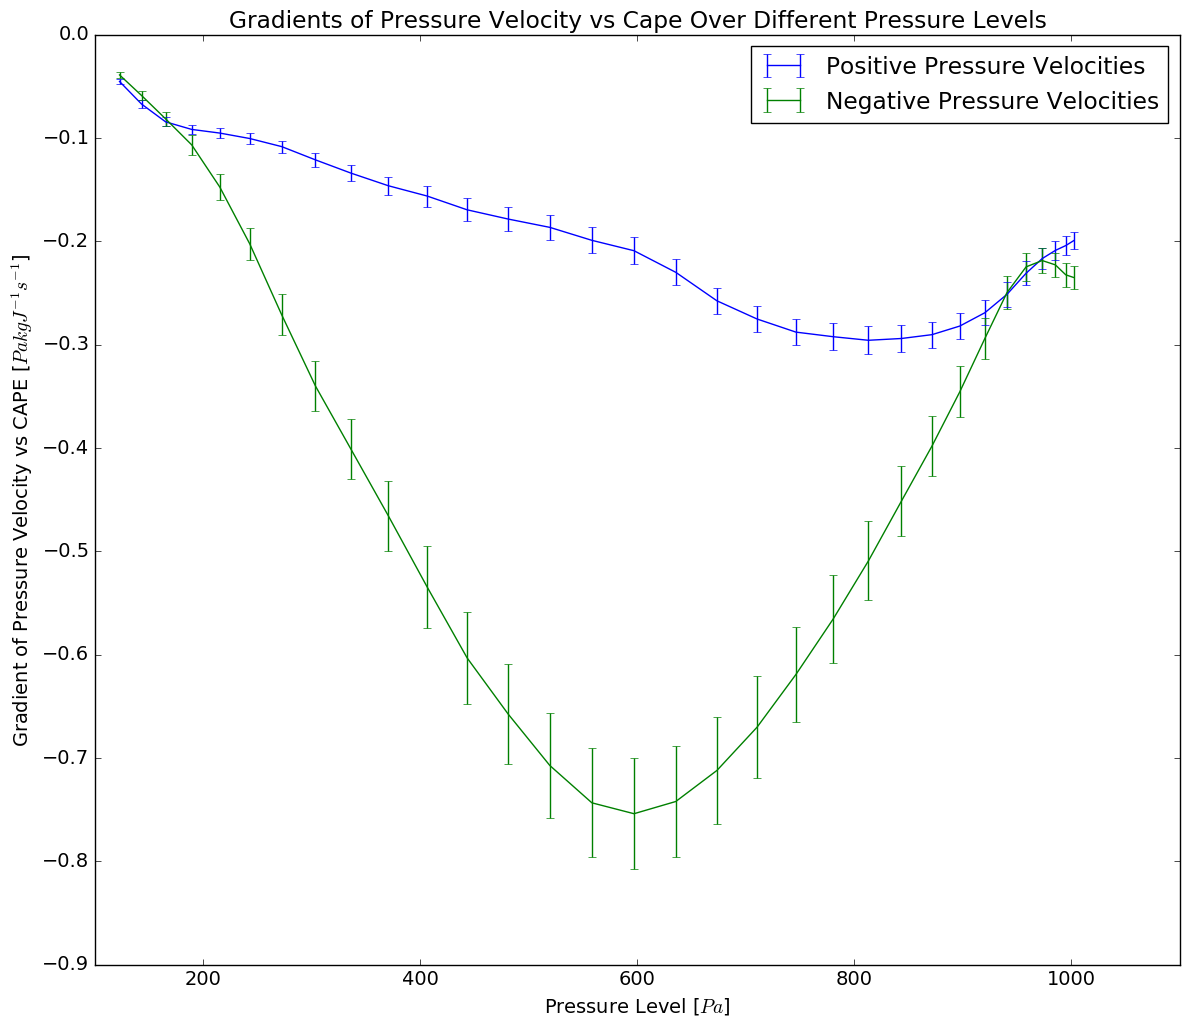

In [12]:
def gradient_function(x_arr,y_arr,n_bins,x_min,x_max,n_max):
    #Function to find the gradient for two parameters, varied over a third parameter.
    #coded for the Pressure velocity vs Cape gradient, which varies with pressure level and 
    #direction of velocity
    
    #This function is for data sets ,y_arr, where one wants to split positive and negative values
    
    params = [[],[]]
    
    resids = [[],[]]

    for i in range(np.shape(y_arr)[1]):
    
        #taking max values in bins
        x_bins,y_vals = bin_max_function(n_bins,x_min,x_max,x_arr,y_arr[:,i],n_max)
    
        #taking negative w values
        y_n,x_n = negative_vals(y_arr[:,i],x_arr)
    
        #taking max negative values
        x_bins_n,y_vals_n = bin_max_function(n_bins,x_min,x_max,x_n,y_n,n_max)
        
        #combining bins for iteration
        bins = [x_bins,x_bins_n]
        
        vals = [y_vals,y_vals_n]
        
        for k in np.arange(len(params)):

            #polyfit called, linear fit used
            param,res = np.polyfit(bins[k].flatten(),vals[k].flatten(),1,cov=True)
            
            #correct positive or negative parameter appended to
            params[k] = np.append(params[k],param[0])
            
            #positive or negative residuals appended to
            resids[k] = np.append(resids[k],np.sqrt((np.diagonal(res))[0]))
    
    #outputs gradient and residuals for positive and then negative respectively
    return params[0],resids[0],params[1],resids[1]

#gradient function called
grad_p,err_p,grad_n,err_n = gradient_function(cape_array,w_array,50,10,4000,5)

#figure made
fig,ax = plt.subplots(figsize=(14,12))

#title created
ax.set_title('Gradients of Pressure Velocity vs Cape Over Different Pressure Levels')

#labels set
ax.set(ylabel='Gradient of Pressure Velocity vs CAPE [$Pa kg J^{-1}s^{-1}$]',
       xlabel='Pressure Level [$Pa$]')

#Errorbar plots made for both positive and negative pressure velocities 
ax.errorbar(plev,grad_p*1000,yerr=err_p*1000,color='blue',label='Positive Pressure Velocities')

ax.errorbar(plev,grad_n*1000,yerr= err_n*1000,color='green',label='Negative Pressure Velocities')

plt.legend()

plt.show()
    

As before, we find all gradients are negative. We note as well, however, that both negative and positive pressure velocities show only very weak negative trends against CAPE for the uppermost cloud levels (lower pressure level). Thereafter, the negative and positive pressure velocities diverge greatly in their gradients, both in their functional form and simply in separation. The negative pressure velocity values appear to drop down in a far more dramatic way, almost parabolic about 600 Pa. On the other hand, the positive values reach a trough closer to 800 Pascal.

We confirm that the negative velocities have much greater negative trends against CAPE and that both positive and negative curves decrease away from the pressure extremes. Additionally, the errorbars on the positive curve reinforce the less chaotic nature of those measurements and we also observe significant increase in randomness at the mid pressure level for both curves,as before.

We next look to explore the overall distribution of pressure velocity values, mainly considering the skew towards positive or negative velocities for different pressure levels.

### Pressure Velocity Skew Investigation

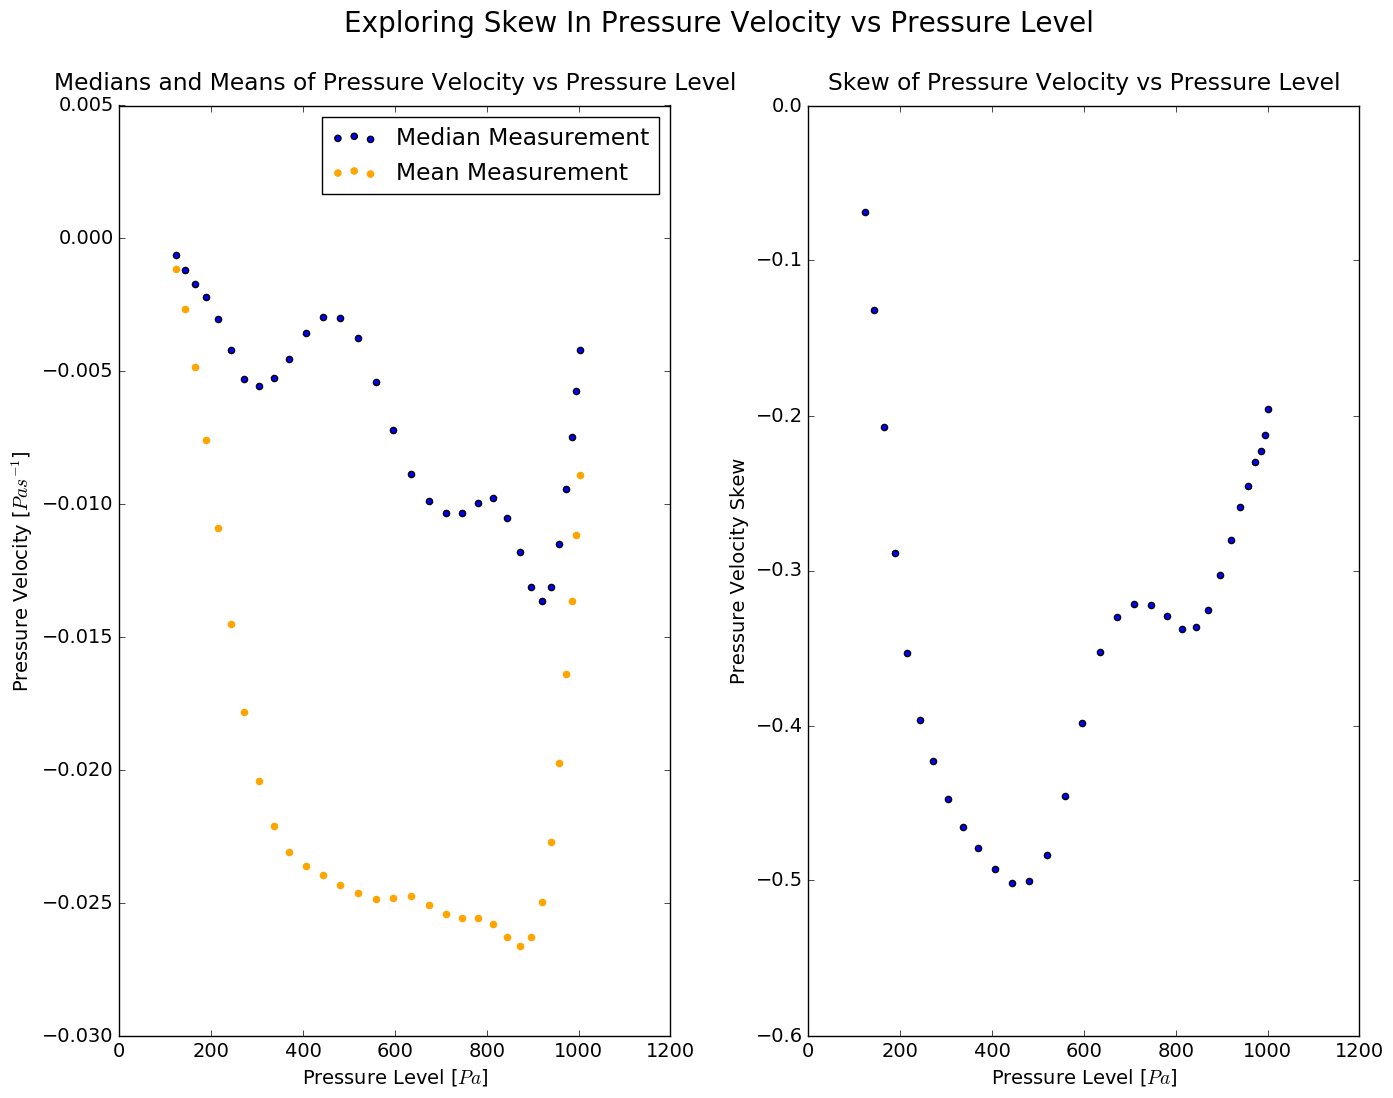

In [13]:
#array of titles is made
w_titles = ['Medians and Means of Pressure Velocity vs Pressure Level',
            'Skew of Pressure Velocity vs Pressure Level']

#arrays of labels compiled
w_x_labels = ['Pressure Level [$Pa$]','Pressure Level [$Pa$]']

w_y_labels = ['Pressure Velocity [$Pa s^{-1}$]','Pressure Velocity Skew']


def skew_plot(xdata,ydata,superior_title,titles,xlabels,ylabels):
    #produces skew plots for a certain set of measurements. ydata is 2d and is broken into arrays corresponding
    #different xdata values. the skew of each subarray is then plotted against xdata.
    
    #empty arrays created
    medians = []

    means = []
    
    skews = []
    
    #figure made
    fig,(axes) = plt.subplots(1,2,figsize=(16,12))
    
    plt.suptitle(superior_title,size=20)
    
    
    for i in range(len(xdata)):
        
        #median,mean and skew calculated for each subarray, each xdata value
        median = np.median(ydata[:,i])
        
        mean = np.mean(ydata[:,i])
        
        skew = 3*(mean - median)/np.std(ydata[:,i])

        #the statistics arrays are appended to for each subarray
        medians = np.append(medians,median)
    
        means = np.append(means,mean)
        
        skews = np.append(skews,skew)
    
    
    #axes are iterated over
    for k,axis in enumerate(axes.flat):
        
        #titles set using titles inout array
        axis.set_title(titles[k],y=1.01)
        
        #Labels inputted from various function inputs
        axis.set(xlabel=xlabels[k],ylabel=ylabels[k])
        
        if k == 0:
            
            #medians and means scattered
            axis.scatter(xdata,medians,label='Median Measurement')
            
            axis.scatter(xdata,means,color='orange',label='Mean Measurement')
            
            #legend for this subplot only
            axis.legend()
     
    
        else:
            
            #skews scattered
            axis.scatter(xdata,skews)

    
    #space between plots adjusted
    plt.subplots_adjust(wspace=.25, hspace=0.45)
    
    plt.show()
    
    return

skew_plot(plev,w_array,'Exploring Skew In Pressure Velocity vs Pressure Level',w_titles,w_x_labels,w_y_labels)


## scrap code

In [ ]:
x = np.random.randint(1,50,(3,3))

print(x)

def maxk(matrix,k):
    
    matrix_new = matrix.flatten()
    
    matrix_new = np.sort(matrix_new)
    
    return matrix_new[-k:]


#print(maxk(x,3))

print('##########################')


def maxk_arg(matrix,k):
    
    matrix_new = matrix.flatten()
    
    matrix_arg = np.argsort(matrix_new)
    
    return matrix_arg[-k:]

#z = maxk_arg(x,3)

#y = x.flatten()

#print(z)

#print(y[z])

sl = slice(0,1)

#y = np.transpose(x,axes=[,1,1])

print(y)

print(y[sl])





In [ ]:

x = [1,2,3,4,5,6]

sl = slice(0,None)

x[sl]


In [ ]:
"""
for i,year in enumerate(years):
    
    file = 'colloc_' + str(year) + '_NZ.nc'
    
    if i == 0:
        
        pmax = (xr.open_dataset(file)).pmax.data
        
        cape = (xr.open_dataset(file)).cape.data
        
        w = ((xr.open_dataset(file)).w.data)[15,:]
        
    else:
    
        pmax = np.vstack((pmax,(xr.open_dataset(file)).pmax.data))
    
        cape = np.vstack((cape,(xr.open_dataset(file)).cape.data))
    
        w = np.vstack((w,((xr.open_dataset(file)).w.data)[15,:]))
"""   
        
"""        
        
        
            
        x_bins[i] = np.mean(x_variable(j))
            
        y_bins[i] = np.mean(y_variable(j))
        var1_bins[i] = np.percentile(pmax(j),pc1)
        var2_bins[i] = np.percentile(pmax(j),pc2)
    
    return x_bins,y_bins,y_bins_pc1,y_bins_pc2


n_bin = 20
n_max_elements = 5

temps = np.linspace(50,5000,n_bin)

pvals = []
cvals = []
wvals = []

for i,value in enumerate(temps[:-1]):
    
    jj = np.where(cape>= value and cape < temps[i+1])
    
    pp = pmax[jj]
    
    cc = cape[jj]
    
    ww = w[jj]
"""    
"""
#cape_1 = (xr.open_dataset(file_years[2]))['cape']

#print(len(w_1),len(cape_1))

#print(np.shape(w_1),np.shape(cape_1))

print(w_1)

#x = w_1.isel(= slice(13,15))


#print(x)

#print(cape_1)
"""

In [ ]:

"""
fig,ax = plt.subplots(figsize =(9,8))

#Precipitation as function of CAPE is plotted

ax.scatter(cape_values_p,pmax_values)
#ax.scatter(np.log(cape_values_p),np.log(pmax_values))

ax.set(xlabel = 'CAPE [$J Kg^-1$]')
ax.set(ylabel = "Precipitation intensity  [$mm h^{-1}$]")
ax.set_title('Precipitation intensity vs CAPE')

plt.show()



fig,ax = plt.subplots(figsize =(9,8))

#log of Pressure velocity as function of log of CAPE

ax.scatter(cape_values_w,w_values)
#ax.scatter(np.log(cape_values_w),np.log(w_values))

ax.set(xlabel = 'CAPE [$J Kg^-1$]')
ax.set(ylabel = "Pressure Velocity  [$Pa s^{-1}$]")
ax.set_title('Pressure velocity vs CAPE')

plt.show()


fig,ax = plt.subplots(figsize =(9,8))

#Precipitation as function of CAPE

ax.scatter(w_values,pmax_values)
#ax.scatter(np.log(w_values),np.log(pmax_values))

ax.set(xlabel = 'Pressure Velocity  [$Pa s^{-1}$]')
ax.set(ylabel = "Precipitation intensity  [$mm h^{-1}$]")
ax.set_title('pmax vs Pressure velocity')

plt.show()

"""

In [ ]:

"""
fig,ax = plt.subplots(figsize =(9,8))
#Precipitation as function of CAPE

ax.scatter(cape_values_n,w_values_n)
#ax.scatter(np.log(cape_values_n),np.log(w_values_n))

#setting labels and titles
ax.set(xlabel = 'CAPE [$J Kg^-1$]')
ax.set(ylabel = "Pressure Velocity  [$Pa s^{-1}$]")
ax.set_title('Negative Pressure velocity vs CAPE ')


plt.show()


cape_values_np,pmax_values_n = bin_max_function(30,10,3500,cape_array_n,pmax_array,n_max =5)


fig,ax = plt.subplots(figsize =(9,8))
#Precipitation as function of CAPE

ax.scatter(cape_values_np,pmax_values_n)
#ax.scatter(np.log(cape_values_np),np.log(pmax_values_n))

#setting labels and titles
ax.set(xlabel = 'CAPE [$J Kg^-1$]')
ax.set(ylabel = "Precipitation intensity  [$mm h^{-1}$]")
ax.set_title('Pmax (negative) vs CAPE ')


plt.show()


def gradient_function(x_arr,y_arr,n_bins,x_min,x_max,n_max):
    
    params_p,resids_p = [],[]

    params_n,resids_n = [],[]
    
    params = [params_p,params_n]
    
    resids = [resids_p,resids_n]

    for i in range(np.shape(y_arr)[1]):
    
    #taking max values in bins
    cape_bins,w_vals = bin_max_function(100,10,4000,cape_array,w_array[:,i],n_max =5)
    
    #Applying linear fit
    pars_p,res_p = np.polyfit(cape_bins.flatten(),w_vals.flatten(),1,cov=True)
        
    #extracting fit parameters
    params_p = np.append(params_p,pars_p[0])
    
    #extracting residuals
    resids_p = np.append(resids_p,np.sqrt(np.diagonal(res_p)[0]))
    
    
    #taking negative w values
    w_n,cape_n = negative_vals(w_array[:,i],cape_array)
    
    #taking max negative values
    cape_bins_n,w_vals_n = bin_max_function(100,10,4000,cape_n,w_n,n_max =5)
    
    #Applying linear fit
    pars_n,res_n = np.polyfit(cape_bins_n.flatten(),w_vals_n.flatten(),1,cov=True)
    
    #extracting fit parameters
    params_n = np.append(params_n,pars_n[0])
    
    #extracting residuals
    resids_n = np.append(resids_n,np.sqrt(np.diagonal(res_n)[0]))
    
plt.errorbar(plev,params_p*1000,yerr=resids_p*1000)

#plt.show()

plt.errorbar(plev,params_n*1000,yerr=resids_n*1000)

plt.show()
    
"""

"""
bowley = []

for i in range((np.shape(w_array))[1]):
    
    b_val_num = np.percentile(w_array[i],75) + np.percentile(w_array[i],25) - 2*np.percentile(w_array[i],50)
    
    b_val_den = np.percentile(w_array[i],75) - np.percentile(w_array[i],25)
    
    bowley = np.append(bowley,(b_val_num/b_val_den))
    
plt.scatter(plev,bowley)


plt.show()
"""

"""
medians = []

means = []

for i in range((np.shape(w_array))[1]):
    
    medians = np.append(medians,np.median(w_array[:,i]))
    
    means = np.append(means,np.mean(w_array[:,i]))
    
plt.scatter(plev,medians)

plt.scatter(plev,means,color ='orange')

plt.show()

skew_2 = []

for i in range((np.shape(w_array))[1]):
    
    skew_val = 3*(np.mean(w_array[:,i]) - np.median(w_array[:,i]))/np.std(w_array[:,i])
    
    skew_2 = np.append(skew_2,skew_val)
    

plt.scatter(plev,skew_2)

plt.show()
"""

    #r = random.random() 
    #b = random.random() 
    #g = random.random()
    
"""
#taking array values less than 0, negative values
indices = np.where(w_array_mid<0)

#creating a new array of just negative values from w
w_array_n = w_array_mid[indices]

#taking cape values corresponding to negative w
cape_array_n = cape_array[indices]

#making the values positive for logarithms
w_array_n = -1*w_array_n
"""


In [ ]:
x = np.reshape([1,2,3,4,5,6,7,8,9],(3,3))

print(x)

z = np.diagonal(x)

print(z)

In [ ]:
x = [[1,3],[1,5],[1,7]]

for i,xs in enumerate(x):
    
    x[i] = np.mean(xs)
    
print(x)

